In [131]:
import pandas as pan
import numpy as np
import matplotlib.pyplot as plotter
import seaborn as sns
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [132]:
feature = np.linspace(0, 50, 501) #time step
label = np.sin(feature)#data

<Axes: >

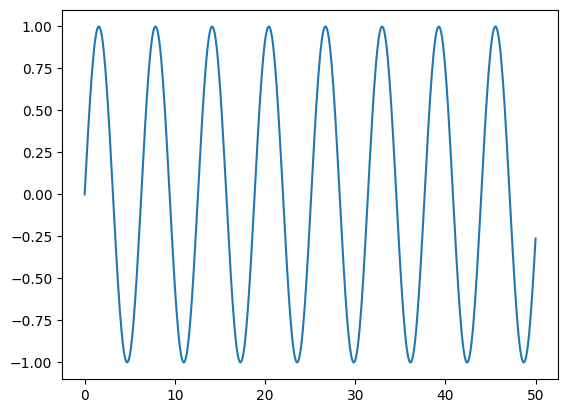

In [133]:
sns.lineplot(x = feature, y = label)

In [134]:
sine_data = pan.DataFrame(data = label, index = feature, columns = ["Sine"])

In [135]:
test_percent = 0.1
test_point = np.round(len(sine_data) * test_percent)
test_index = int(len(sine_data) - test_point)

In [136]:
train = sine_data.iloc[: test_index]
test = sine_data.iloc[test_index:]

In [137]:
mm_scaler = MinMaxScaler()
train = mm_scaler.fit_transform(train)
test = mm_scaler.transform(test)

In [138]:
length = 50
batch_size = 1
generator = TimeseriesGenerator(train, train, length = length, batch_size = batch_size)

In [139]:
gen_features,gen_labels = generator[0]

In [140]:
gen_features

array([[[4.99999116e-01],
        [5.49916225e-01],
        [5.99334579e-01],
        [6.47760405e-01],
        [6.94709850e-01],
        [7.39713809e-01],
        [7.82322618e-01],
        [8.22110545e-01],
        [8.58680040e-01],
        [8.91665714e-01],
        [9.20737985e-01],
        [9.45606372e-01],
        [9.66022399e-01],
        [9.81782075e-01],
        [9.92727935e-01],
        [9.98750612e-01],
        [9.99789928e-01],
        [9.95835500e-01],
        [9.86926839e-01],
        [9.73152957e-01],
        [9.54651478e-01],
        [9.31607263e-01],
        [9.04250562e-01],
        [8.72854714e-01],
        [8.37733417e-01],
        [7.99237589e-01],
        [7.57751870e-01],
        [7.13690771e-01],
        [6.67494535e-01],
        [6.19624741e-01],
        [5.70559686e-01],
        [5.20789614e-01],
        [4.70811810e-01],
        [4.21125636e-01],
        [3.72227539e-01],
        [3.24606094e-01],
        [2.78737119e-01],
        [2.35078919e-01],
        [1.9

In [141]:
num_features = 1
rnn_learner = Sequential()
rnn_learner.add(SimpleRNN(units = 50, input_shape = (length, num_features), activation = "relu"))
rnn_learner.add(Dense(1, activation = "relu"))
rnn_learner.compile(optimizer = "adam", loss = "mse")

In [142]:
rnn_learner.fit(generator, epochs = 5)

Epoch 1/5
401/401 [==============================] - 4s 7ms/step - loss: 0.0054
Epoch 2/5
401/401 [==============================] - 2s 6ms/step - loss: 9.6569e-06
Epoch 3/5
401/401 [==============================] - 3s 6ms/step - loss: 8.2203e-05
Epoch 4/5
401/401 [==============================] - 2s 6ms/step - loss: 1.9947e-04
Epoch 5/5
401/401 [==============================] - 2s 6ms/step - loss: 1.1885e-05


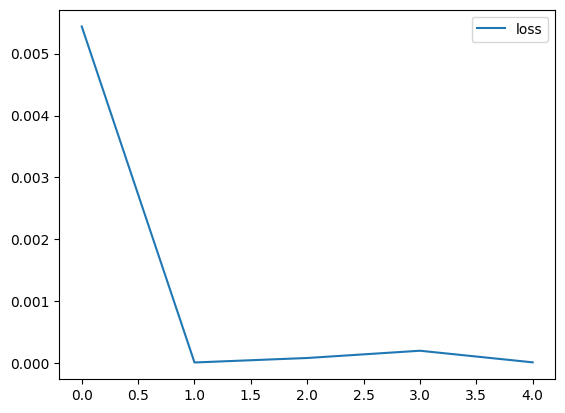

In [143]:
loss = pan.DataFrame(rnn_learner.history.history).plot()

In [144]:
first_eval_batch = train[-length: ]

In [145]:
first_eval_batch = first_eval_batch.reshape((1, length, num_features))

In [146]:
rnn_learner.predict(first_eval_batch)

1/1 [==============================] - 0s 167ms/step


array([[0.95766896]], dtype=float32)

In [147]:
test_predictions = []
eval_batch = train[-length:]#grab evaluation batch (last length observations in the training set)
curr = eval_batch.reshape((1, length, num_features))#reshape, so that it can be acceptable to the model (based off its length and the number of features used to train the model)

for i in range(len(test)):
    curr_pred = rnn_learner.predict(curr)[0]  #first prediction given by the learner
    test_predictions.append(curr_pred)#appended, so we can compare with the test set
    curr = np.append(curr[:, 1:, :], [[curr_pred]], axis = 1)#appends the prediction to the curr ndarray, while removing the first element in the length dimension: note the 1:

1/1 [==============================] - 0s 28ms/step


In [148]:
true_predictions = mm_scaler.inverse_transform(test_predictions)

In [149]:
length = 49
generator = TimeseriesGenerator(train, train, length = length, batch_size = 1)
validation_generator = TimeseriesGenerator(test, test, length = length, batch_size = 1)

In [150]:
new_rnnlearner = Sequential()
new_rnnlearner.add(LSTM(units = 50, input_shape = (length, num_features), activation = "relu"))
new_rnnlearner.add(Dense(1, activation = "relu"))
new_rnnlearner.compile(optimizer = "adam", loss = "mse")

In [151]:
stopper = EarlyStopping(patience = 2)
new_rnnlearner.fit(generator, epochs = 25, validation_data = validation_generator, callbacks = [stopper])

Epoch 1/25
402/402 [==============================] - 6s 13ms/step - loss: 0.0212 - val_loss: 1.7464e-06
Epoch 2/25
402/402 [==============================] - 5s 12ms/step - loss: 1.2689e-04 - val_loss: 1.1273e-05
Epoch 3/25
402/402 [==============================] - 5s 12ms/step - loss: 3.3590e-04 - val_loss: 7.8376e-05


In [152]:
test_predictions_two = []
eval_batch = train[-length:]#grab evaluation batch (last length observations in the training set)
curr = eval_batch.reshape((1, length, num_features))#reshape, so that it can be acceptable to the model (based off its length and the number of features used to train the model)

for i in range(len(test)):
    curr_pred = new_rnnlearner.predict(curr)[0]  #first prediction given by the learner
    test_predictions_two.append(curr_pred)#appended, so we can compare with the test set
    np.append(curr[:, 1:, :], [[curr_pred]], axis = 1)#appends the prediction to the curr ndarray, while removing the first element in the length dimension: note the 1:

1/1 [==============================] - 0s 22ms/step


In [153]:
true_predictions_two = mm_scaler.inverse_transform(test_predictions_two)

In [154]:
#forecasting
full_mmscaler = MinMaxScaler()
entire_data = full_mmscaler.fit_transform(sine_data)

In [155]:
generator = TimeseriesGenerator(entire_data, entire_data, length = length, batch_size = 1)
newer_rnnlearner = Sequential()
newer_rnnlearner.add(LSTM(units = 50, input_shape = (length, num_features), activation = "relu"))
newer_rnnlearner.add(Dense(1, activation = "relu"))
newer_rnnlearner.compile(optimizer = "adam", loss = "mse")

In [156]:
newer_rnnlearner.fit(generator, epochs = 10)

Epoch 1/10
452/452 [==============================] - 7s 11ms/step - loss: 0.0205
Epoch 2/10
452/452 [==============================] - 5s 11ms/step - loss: 2.4689e-05
Epoch 3/10
452/452 [==============================] - 5s 11ms/step - loss: 8.0057e-06
Epoch 4/10
452/452 [==============================] - 5s 11ms/step - loss: 5.6228e-05
Epoch 5/10
452/452 [==============================] - 5s 11ms/step - loss: 6.2354e-04
Epoch 6/10
452/452 [==============================] - 5s 11ms/step - loss: 1.8336e-06
Epoch 7/10
452/452 [==============================] - 5s 11ms/step - loss: 9.2494e-06
Epoch 8/10
452/452 [==============================] - 5s 11ms/step - loss: 2.8545e-04
Epoch 9/10
452/452 [==============================] - 5s 11ms/step - loss: 6.4690e-06
Epoch 10/10
452/452 [==============================] - 5s 11ms/step - loss: 9.5976e-05


In [157]:
forecast = []
eval_batch = train[-length:]#grab evaluation batch (last length observations in the training set)
curr = eval_batch.reshape((1, length, num_features))#reshape, so that it can be acceptable to the model (based off its length and the number of features used to train the model)

for i in range(20):
    curr_pred = newer_rnnlearner.predict(curr)[0]  #first prediction given by the learner
    forecast.append(curr_pred)#appended, so we can compare with the test set
    curr = np.append(curr[:, 1:, :], [[curr_pred]], axis = 1)#appends the prediction to the curr ndarray, while removing the first element in the length dimension: note the 1:

1/1 [==============================] - 0s 27ms/step


In [158]:
forecast = full_mmscaler.inverse_transform(forecast)

In [159]:
forecast_index = np.arange(50.1, 52.1, step = 0.1)

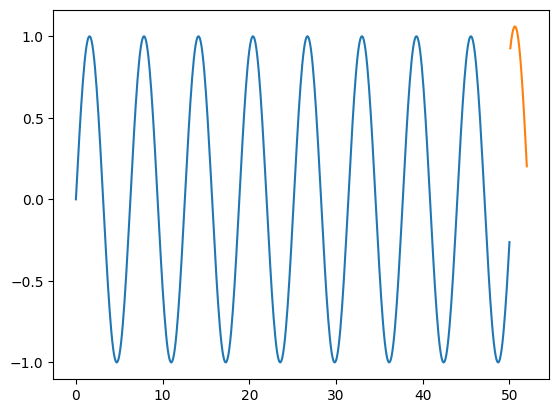

In [162]:
plotter.plot(sine_data.index , sine_data)
plotter.plot(forecast_index, forecast)